# Attack statistics

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import time

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from IPython.display import HTML, display

from nlp_adversarial_attacks.utils.notebook import (
    CMAP,
    CMAP_R,
    display_freq_categorical,
    display_side_by_side,
    load_attack,
)

sns.set_style("white")

## Dataset Allociné

In [3]:
df_test = pd.read_csv("data/allocine/test.csv")
df_test

,text,label
0,"Magnifique épopée, une belle histoire, touchan...",1
1,Je n'ai pas aimé mais pourtant je lui mets 2 é...,0
2,Un dessin animé qui brille par sa féerie et se...,1
3,"Si c'est là le renouveau du cinéma français, c...",0
4,Et pourtant on s’en Doutait !Second volet très...,0
...,...,...
19995,"je suis éventreur, arracheur, tailladeur, goug...",1
19996,Trémors 3 essouffle la série des trémors par u...,0
19997,"0/20 : Tout d’abord, la mise en scène est tout...",0
19998,Un scénario très original mené par des personn...,1


In [4]:
def describe_data(df):
    df = df.copy()

    df["label"] = df["label"].replace({0: "Negative", 1: "Positive"})

    # display datasets
    display(df)

    # statistics
    df["Word count"] = df["text"].apply(lambda x: len(x.split()))
    print(f"Number of observations: {len(df):,}")

    display_freq_categorical(df["label"])

    sns.histplot(
        df,
        x="Word count",
        kde=True,
        stat="probability",
        bins=25,
        line_kws={"linewidth": 2},
    )
    plt.savefig("report/word_count.pdf")
    plt.show()
    # display(df[["word_len"]].describe())

,text,label
0,"Magnifique épopée, une belle histoire, touchan...",Positive
1,Je n'ai pas aimé mais pourtant je lui mets 2 é...,Negative
2,Un dessin animé qui brille par sa féerie et se...,Positive
3,"Si c'est là le renouveau du cinéma français, c...",Negative
4,Et pourtant on s’en Doutait !Second volet très...,Negative
...,...,...
19995,"je suis éventreur, arracheur, tailladeur, goug...",Positive
19996,Trémors 3 essouffle la série des trémors par u...,Negative
19997,"0/20 : Tout d’abord, la mise en scène est tout...",Negative
19998,Un scénario très original mené par des personn...,Positive


Number of observations: 20,000


,Frequency,Percent
label,,
Negative,10408,52.04%
Positive,9592,47.96%


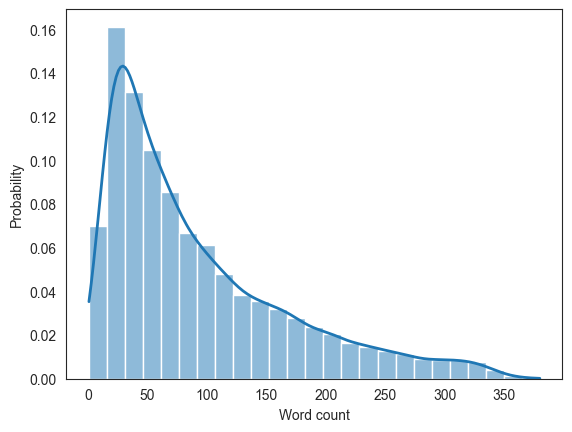

In [5]:
describe_data(df_test)

## Attack

In [6]:
def display_crosstab(df, column1, column2):
    df1 = pd.crosstab(
        df[column1],
        df[column2],
        margins=True,
    )
    df2 = pd.crosstab(df[column1], df[column2], margins=True, normalize="index")
    display_side_by_side([df1, df2.style.format("{:.2%}")])


def describe_attack(attack):
    config = attack["config"]
    summary = attack["summary"]

    n_samples = config["attack_n_samples"]
    attack_time = summary["Attack time"]

    display(HTML(f"<h3>Attack name: {config['attack_name']}</h3>"))
    print(f"N_samples: {n_samples}")
    print(
        f"Attack time: {time.strftime('%H:%M:%S', time.gmtime(attack_time))} ({attack_time/n_samples} s/it)"
    )

    df = attack["df_results"].copy()

    # statistics
    success = summary["Number of successful attacks:"]
    failed = summary["Number of failed attacks:"]
    rate = summary["Attack success rate:"] / 100
    display(
        HTML(
            f"<b>Attack success rate:  {success}/{success + failed}  -  {rate:.2%}</b>"
        )
    )

    display_crosstab(df, "status", "label")

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    hue_order = ["success", "failed"]
    sns.histplot(
        df,
        x="frac_words_changed",
        hue="status",
        hue_order=hue_order,
        kde=True,
        stat="probability",
        bins=25,
        line_kws={"linewidth": 2},
        ax=ax[0],
    )
    sns.histplot(
        df,
        x="num_queries",
        hue="status",
        hue_order=hue_order,
        kde=True,
        stat="probability",
        bins=25,
        line_kws={"linewidth": 2},
        ax=ax[1],
    )
    plt.show()

N_samples: 2000
Attack time: 00:40:15 (1.2075 s/it)


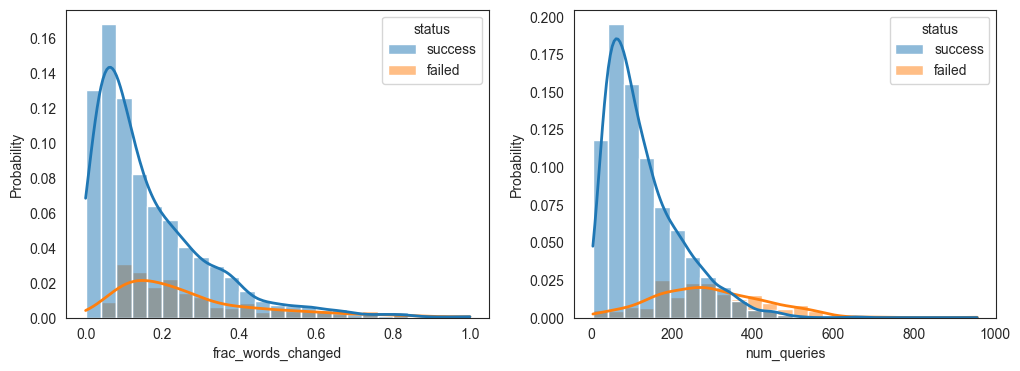

In [7]:
attack = load_attack("attacks/allocine/distilcamembert/textattack/deepwordbug/2000")
describe_attack(attack)

In [8]:
def describe_attack_list(attack_list):
    df_list = []
    for attack in attack_list:
        config = attack["config"]
        summary = attack["summary"]
        dico = {
            "Attack name": config["attack_name"],
            "N_samples": config["attack_n_samples"],
            "Success attacks": summary["Number of successful attacks:"],
            "Failed attacks": summary["Number of failed attacks:"],
            "Attack success rate": summary["Attack success rate:"] / 100,
            "Accuracy under attack": summary["Accuracy under attack:"] / 100,
            # "Original accuracy": summary["Original accuracy:"] / 100,
            "Avg perturbed word": summary["Average perturbed word %:"] / 100,
            # "Avg num. words": summary["Average num. words per input:"],
            "Avg num queries": summary["Avg num queries:"],
            "Avg attack time": summary["Attack time"] / config["attack_n_samples"],
        }
        df_list.append(dico)

    df = pd.DataFrame(df_list)

    lower_better = [
        "Failed attacks",
        "Accuracy under attack",
        "Avg perturbed word",
        "Avg num queries",
        "Avg attack time",
    ]
    greater_better = [
        "Success attacks",
        "Attack success rate",
    ]

    df_style = (
        df.style.format(
            {
                "Attack success rate": "{:.2%}",
                "Accuracy under attack": "{:.2%}",
                "Original accuracy": "{:.2%}",
                "Avg perturbed word": "{:.2%}",
                "Avg num. words": "{:.2f}",
                "Avg num queries": "{:.2f}",
                "Avg attack time": "{:.2f} s/it",
            },
        )
        .background_gradient(cmap=CMAP, subset=greater_better)
        .background_gradient(cmap=CMAP_R, subset=lower_better)
    )
    display(df_style)
    # print(df_style.hide_index().format(precision=3, escape="latex").to_latex(convert_css=True))

    plt.figure(figsize=(6, 4))
    x = "Avg perturbed word"
    y = "Attack success rate"
    sns.scatterplot(df, x=x, y=y)
    for i in range(df.shape[0]):
        y_pos = df[y][i] + 0.01
        if i == 1:
            y_pos = df[y][i] - 0.03
        if i == 5:
            y_pos = df[y][i] + 0.03
        plt.text(
            x=df[x][i] + 0.01,
            y=y_pos,
            s=df["Attack name"][i],
            fontdict={"color": "red", "size": 10},
            bbox={"facecolor": "yellow", "alpha": 0.5},
        )
    plt.xlim(df[x].min() - 0.05, df[x].max() + 0.1)
    plt.ylim(df[y].min() - 0.05, df[y].max() + 0.1)
    plt.grid()
    plt.savefig("report/scatter_attack.pdf")
    plt.show()

,Attack name,N_samples,Success attacks,Failed attacks,Attack success rate,Accuracy under attack,Avg perturbed word,Avg num queries,Avg attack time
0,bae,2000,1217,783,60.85%,39.15%,8.25%,221.02,6.07 s/it
1,deepwordbug,2000,1636,364,81.80%,18.20%,16.49%,158.79,1.21 s/it
2,input_reduction,2000,2000,0,100.00%,0.00%,35.55%,154.22,0.89 s/it
3,pwws,2000,741,1259,37.05%,62.95%,11.17%,397.94,2.03 s/it
4,textbugger,2000,1663,337,83.15%,16.85%,31.04%,266.32,1.57 s/it
5,textfooler,2000,1656,344,82.80%,17.20%,14.90%,371.92,2.66 s/it


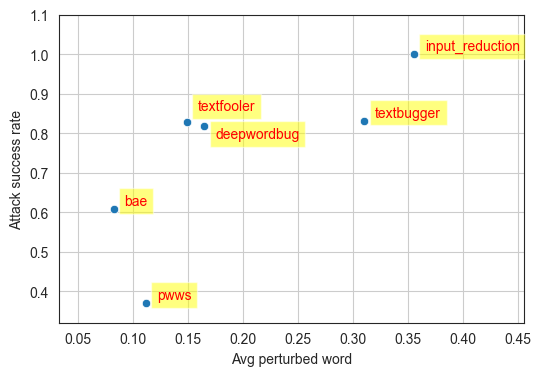

In [9]:
attack_folders = [
    "attacks/allocine/distilcamembert/textattack/bae/2000",
    "attacks/allocine/distilcamembert/textattack/deepwordbug/2000",
    "attacks/allocine/distilcamembert/textattack/input_reduction/2000",
    "attacks/allocine/distilcamembert/textattack/pwws/2000",
    "attacks/allocine/distilcamembert/textattack/textbugger/2000",
    "attacks/allocine/distilcamembert/textattack/textfooler/2000",
]

attack_list = [load_attack(folder) for folder in attack_folders]
describe_attack_list(attack_list)

In [10]:
def describe_concat_dataset(df):
    print(f"N_samples: {len(df)}")

    display_freq_categorical(df["label"])
    display_freq_categorical(df["status"])

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    sns.kdeplot(
        df,
        x="frac_words_changed",
        hue="attack_name",
        ax=ax[0],
    )
    sns.kdeplot(
        df,
        x="num_queries",
        hue="attack_name",
        ax=ax[1],
    )
    plt.show()

    sns.kdeplot(
        df,
        x="frac_words_changed",
        hue="attack_name",
    )
    plt.grid()
    plt.savefig("report/frac_words_changed.pdf")

N_samples: 12000


,Frequency,Percent
label,,
Negative,6378,53.15%
Positive,5622,46.85%


,Frequency,Percent
status,,
success,8913,74.28%
failed,3087,25.72%


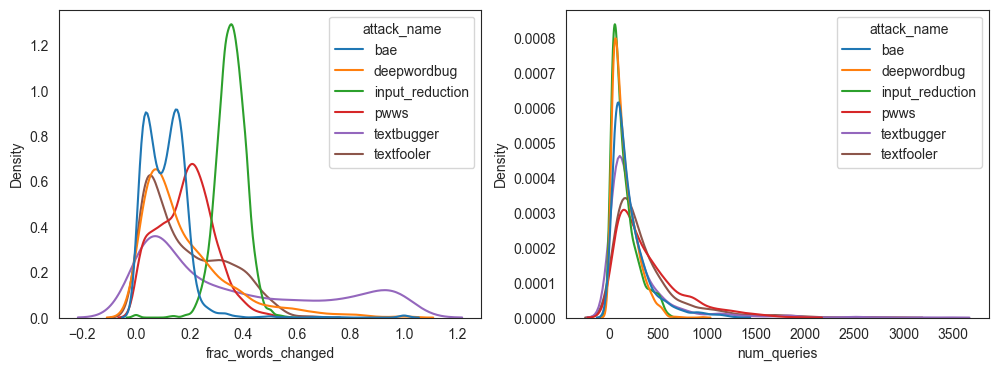

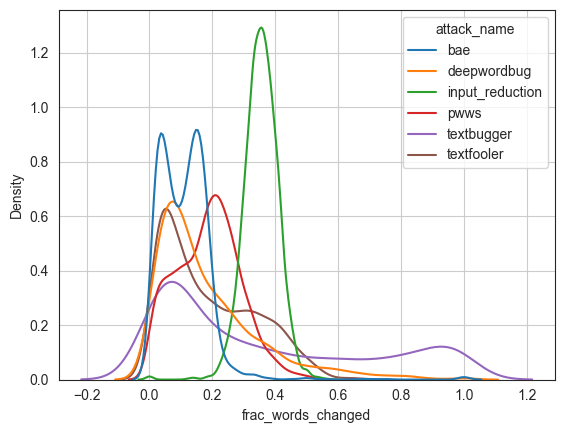

In [11]:
df_concat = pd.concat([attack["df_results"] for attack in attack_list])
describe_concat_dataset(df_concat)